In [1]:
import mldatasets
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
from rulefit import RuleFit
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing\
                                    import Normalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from alepython import ale_plot

In [2]:
print(tf.__version__)

2.2.0


In [3]:
fueleconomy_df = mldatasets.load("vehicle-fueleconomy")

https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter5/data/vehicles.csv.zip
/Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter5/data/vehicles.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter5/data/vehicles.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter5/data/vehicles.csv folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter5/data/vehicles.csv/vehicles.csv


In [4]:
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42445 entries, 0 to 42444
Data columns (total 25 columns):
make              42445 non-null object
model             42445 non-null object
year              42445 non-null int16
fuelType          42445 non-null object
cylinders         42202 non-null float32
displ             42204 non-null float32
trany             42434 non-null object
drive             41259 non-null object
eng_dscr          26064 non-null object
trans_dscr        15047 non-null object
phevBlended       42445 non-null bool
co2TailpipeGpm    42445 non-null float32
co2               42445 non-null int16
ghgScore          42445 non-null int16
VClass            42445 non-null object
pv4               42445 non-null int16
lv4               42445 non-null int16
lv2               42445 non-null int16
pv2               42445 non-null int16
hlv               42445 non-null int16
hpv               42445 non-null int16
startStop         10741 non-null object
tCharger          7

In [5]:
fueleconomy_df.cylinders.fillna(0, inplace=True)
fueleconomy_df.displ.fillna(0, inplace=True)

In [6]:
categorical_l = ['make', 'model', 'fuelType', 'trany', 'drive', 'eng_dscr',\
               'trans_dscr', 'VClass', 'startStop', 'tCharger', 'atvType']
fueleconomy_df[categorical_l].nunique()

make           138
model         4261
fuelType        14
trany           40
drive            7
eng_dscr       561
trans_dscr      52
VClass          34
startStop        2
tCharger         1
atvType          8
dtype: int64

In [7]:
tmp_df = fueleconomy_df[categorical_l]
tmp_df.iloc[np.r_[0:5, -2:0]]

make                model fuelType            trany  \
0      Alfa Romeo   Spider Veloce 2000  Regular     Manual 5-spd   
1         Ferrari           Testarossa  Regular     Manual 5-spd   
2           Dodge              Charger  Regular     Manual 5-spd   
3           Dodge  B150/B250 Wagon 2WD  Regular  Automatic 3-spd   
4          Subaru     Legacy AWD Turbo  Premium     Manual 5-spd   
42443      Subaru           Legacy AWD  Regular     Manual 5-spd   
42444      Subaru     Legacy AWD Turbo  Premium  Automatic 4-spd   

                            drive    eng_dscr trans_dscr           VClass  \
0                Rear-Wheel Drive       (FFS)        NaN      Two Seaters   
1                Rear-Wheel Drive   (GUZZLER)        NaN      Two Seaters   
2               Front-Wheel Drive       (FFS)        SIL  Subcompact Cars   
3                Rear-Wheel Drive         NaN        NaN             Vans   
4      4-Wheel or All-Wheel Drive  (FFS,TRBO)        NaN     Compact Cars   
42443  4-Wheel or All-Wheel Drive       (FFS)        NaN     Compact Cars   
42444  4-Wheel or All-Wheel Drive  (FFS,TRBO)      CLKUP     Compact Cars   

      startStop tCharger atvType  
0           NaN      NaN     NaN  
1           NaN      NaN     NaN  
2           NaN      NaN     NaN  
3           NaN      NaN     NaN  
4           NaN        T     NaN  
42443       NaN      NaN     NaN  
42444       NaN        T     NaN

In [8]:
fueleconomy_df.trans_dscr.fillna('Unknown', inplace=True)
fueleconomy_df.startStop.fillna('Unknown', inplace=True)
fueleconomy_df.tCharger.fillna(0, inplace=True)
fueleconomy_df.tCharger.replace('T', 1, inplace=True)
fueleconomy_df.atvType.fillna('Unknown', inplace=True)
fueleconomy_df.drive.fillna('Unknown', inplace=True)

In [9]:
def make_dummies_with_limits(df, colname, min_recs=0.005,\
                             max_dummies=20, defcolname='Other',\
                             nospacechr='_'):
    if min_recs < 1:
        min_recs = df.shape[0]*0.005
    topvals_df = df.groupby(colname).size().reset_index(name="counts").\
                    sort_values(by="counts", ascending=False).reset_index()
    other_l = topvals_df[(topvals_df.index > max_dummies) |\
                         (topvals_df.counts < min_recs)][colname].to_list()
    if len(other_l):
        df.loc[df[colname].isin(other_l), colname] = defcolname
    if len(nospacechr):
        df[colname] = df[colname].str.replace(' ',\
                                                  nospacechr, regex=False)
    return pd.get_dummies(df, prefix=[colname], columns=[colname])

In [10]:
def make_dummies_from_dict(df, colname, match_dict, 
                           drop_orig=True, nospacechr='_'):
    if type(match_dict) is list:
        if len(nospacechr):
            match_dict = {match_key:match_key.\
                              replace(' ', nospacechr)\
                              for match_key in match_dict }
        else:
            match_dict = {match_key:match_key\
                              for match_key in match_dict}
    for match_key in match_dict.keys():
        df[colname+'_'+match_dict[match_key]] =\
                    np.where(df[colname].str.contains(match_key), 1, 0)
    if drop_orig:
        return df.drop([colname], axis=1)
    else:
        return df

In [11]:
fueleconomy_df['trans_spd'] = fueleconomy_df.trany.str.\
                                    extract('(\d+)').fillna(0).astype(np.int8)

In [12]:
fueleconomy_df = make_dummies_with_limits(fueleconomy_df, 'fuelType')
fueleconomy_df = make_dummies_from_dict(fueleconomy_df, 'trany',\
                                        ['Automatic', 'Manual'])

In [13]:
fueleconomy_df['drive'] = fueleconomy_df['drive'].str.\
                                    replace(' Drive', '', regex=False)
fueleconomy_df = make_dummies_with_limits(fueleconomy_df, 'drive')

In [14]:
fueleconomy_df = make_dummies_from_dict(fueleconomy_df, 'eng_dscr',\
                                    ['FFS','SIDI','CA model','MPFI',\
                                     'FFV','TRBO','350 V8','PFI',\
                                     'GUZZLER','SOHC','NO-CAT'])
fueleconomy_df = make_dummies_from_dict(fueleconomy_df, 'trans_dscr',\
                                    ['Unknown','CLKUP','SIL','2MODE',\
                                     'Creeper','EMS','3MODE','2LKUP'])

In [15]:
fueleconomy_df['VClass'] = fueleconomy_df['VClass'].str.\
                                    replace(' -', '', regex=False)
fueleconomy_df = make_dummies_with_limits(fueleconomy_df, 'VClass')
fueleconomy_df = make_dummies_with_limits(fueleconomy_df, 'startStop')
fueleconomy_df = make_dummies_with_limits(fueleconomy_df, 'atvType')

In [16]:
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42445 entries, 0 to 42444
Data columns (total 84 columns):
make                                         42445 non-null object
model                                        42445 non-null object
year                                         42445 non-null int16
cylinders                                    42445 non-null float32
displ                                        42445 non-null float32
phevBlended                                  42445 non-null bool
co2TailpipeGpm                               42445 non-null float32
co2                                          42445 non-null int16
ghgScore                                     42445 non-null int16
pv4                                          42445 non-null int16
lv4                                          42445 non-null int16
lv2                                          42445 non-null int16
pv2                                          42445 non-null int16
hlv                       

In [17]:
rand = 9
y = fueleconomy_df['comb08']
X = fueleconomy_df.drop(['comb08','make','model'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                    test_size=0.15, random_state=rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                    test_size=0.2, random_state=rand)

In [18]:
np.random.seed(rand)
tf.random.set_seed(rand)

In [19]:
fitted_nn_model = keras.Sequential([
    tf.keras.Input(shape=[len(X_train.keys())]),
    Normalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
fitted_nn_model.compile(loss='mean_squared_error',\
                optimizer=keras.optimizers.Adam(lr = 0.0005),\
                metrics=['mse'])
fitted_nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 81)                163       
_________________________________________________________________
dense (Dense)                (None, 64)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,636
Trainable params: 9,473
Non-trainable params: 163
_________________________________________________________________


In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,\
                                      patience=150, min_delta=0.001,\
                                      restore_best_weights=True)
nn_history = fitted_nn_model.fit(\
                X_train.astype(float), y_train.astype(float), epochs=3000, batch_size=128,\
                validation_data=(X_val.astype(float), y_val.astype(float)), verbose=1,\
                                 callbacks=[es])

Epoch 1/3000
226/226 [==============================] - 1s 3ms/step - loss: 403.0585 - mse: 403.0585 - val_loss: 9.0627 - val_mse: 9.0627
Epoch 2/3000
226/226 [==============================] - 0s 2ms/step - loss: 9.2265 - mse: 9.2265 - val_loss: 7.0857 - val_mse: 7.0857
Epoch 3/3000
226/226 [==============================] - 0s 2ms/step - loss: 7.4876 - mse: 7.4876 - val_loss: 6.1218 - val_mse: 6.1218
Epoch 4/3000
226/226 [==============================] - 1s 2ms/step - loss: 6.4411 - mse: 6.4411 - val_loss: 5.0563 - val_mse: 5.0563
Epoch 5/3000
226/226 [==============================] - 0s 2ms/step - loss: 5.6549 - mse: 5.6549 - val_loss: 4.5182 - val_mse: 4.5182
Epoch 6/3000
226/226 [==============================] - 0s 2ms/step - loss: 4.8861 - mse: 4.8861 - val_loss: 3.7603 - val_mse: 3.7603
Epoch 7/3000
226/226 [==============================] - 0s 2ms/step - loss: 4.3961 - mse: 4.3961 - val_loss: 3.5284 - val_mse: 3.5284
Epoch 8/3000
226/226 [==============================] - 1s

Epoch 62/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.8879 - mse: 1.8879 - val_loss: 1.3728 - val_mse: 1.3728
Epoch 63/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.7765 - mse: 1.7765 - val_loss: 1.5047 - val_mse: 1.5047
Epoch 64/3000
226/226 [==============================] - 1s 3ms/step - loss: 2.0181 - mse: 2.0181 - val_loss: 2.4395 - val_mse: 2.4395
Epoch 65/3000
226/226 [==============================] - 1s 3ms/step - loss: 2.1861 - mse: 2.1861 - val_loss: 1.2321 - val_mse: 1.2321
Epoch 66/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.8344 - mse: 1.8344 - val_loss: 1.2477 - val_mse: 1.2477
Epoch 67/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.9061 - mse: 1.9061 - val_loss: 2.5537 - val_mse: 2.5537
Epoch 68/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.8663 - mse: 1.8663 - val_loss: 1.1349 - val_mse: 1.1349
Epoch 69/3000
226/226 [==============================] 

226/226 [==============================] - 1s 2ms/step - loss: 1.7777 - mse: 1.7777 - val_loss: 0.9920 - val_mse: 0.9920
Epoch 123/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.5696 - mse: 1.5696 - val_loss: 1.0594 - val_mse: 1.0594
Epoch 124/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.7266 - mse: 1.7266 - val_loss: 1.1328 - val_mse: 1.1328
Epoch 125/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.4583 - mse: 1.4583 - val_loss: 1.1753 - val_mse: 1.1753
Epoch 126/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.4758 - mse: 1.4758 - val_loss: 1.2585 - val_mse: 1.2585
Epoch 127/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.6419 - mse: 1.6419 - val_loss: 1.9180 - val_mse: 1.9180
Epoch 128/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.5814 - mse: 1.5814 - val_loss: 1.1055 - val_mse: 1.1055
Epoch 129/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 3ms/step - loss: 1.3957 - mse: 1.3957 - val_loss: 0.9199 - val_mse: 0.9199
Epoch 183/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.5316 - mse: 1.5316 - val_loss: 0.9326 - val_mse: 0.9326
Epoch 184/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.3934 - mse: 1.3934 - val_loss: 1.0593 - val_mse: 1.0593
Epoch 185/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.4284 - mse: 1.4284 - val_loss: 1.2215 - val_mse: 1.2215
Epoch 186/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.4413 - mse: 1.4413 - val_loss: 0.9392 - val_mse: 0.9392
Epoch 187/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.3833 - mse: 1.3833 - val_loss: 0.9003 - val_mse: 0.9003
Epoch 188/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.3281 - mse: 1.3281 - val_loss: 3.4072 - val_mse: 3.4072
Epoch 189/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 2ms/step - loss: 1.3088 - mse: 1.3088 - val_loss: 1.0899 - val_mse: 1.0899
Epoch 243/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.2611 - mse: 1.2611 - val_loss: 0.9231 - val_mse: 0.9231
Epoch 244/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2001 - mse: 1.2001 - val_loss: 0.9231 - val_mse: 0.9231
Epoch 245/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.3159 - mse: 1.3159 - val_loss: 0.9571 - val_mse: 0.9571
Epoch 246/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2235 - mse: 1.2235 - val_loss: 2.0463 - val_mse: 2.0463
Epoch 247/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.3913 - mse: 1.3913 - val_loss: 1.3166 - val_mse: 1.3166
Epoch 248/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2837 - mse: 1.2837 - val_loss: 1.0426 - val_mse: 1.0426
Epoch 249/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 2ms/step - loss: 1.2505 - mse: 1.2505 - val_loss: 1.4219 - val_mse: 1.4219
Epoch 303/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2428 - mse: 1.2428 - val_loss: 1.2461 - val_mse: 1.2461
Epoch 304/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2070 - mse: 1.2070 - val_loss: 0.9528 - val_mse: 0.9528
Epoch 305/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2763 - mse: 1.2763 - val_loss: 0.9323 - val_mse: 0.9323
Epoch 306/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1680 - mse: 1.1680 - val_loss: 1.2511 - val_mse: 1.2511
Epoch 307/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1932 - mse: 1.1932 - val_loss: 0.9594 - val_mse: 0.9594
Epoch 308/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2257 - mse: 1.2257 - val_loss: 0.8508 - val_mse: 0.8508
Epoch 309/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 3ms/step - loss: 1.1352 - mse: 1.1352 - val_loss: 0.8258 - val_mse: 0.8258
Epoch 363/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0910 - mse: 1.0910 - val_loss: 1.2663 - val_mse: 1.2663
Epoch 364/3000
226/226 [==============================] - 1s 3ms/step - loss: 1.1233 - mse: 1.1233 - val_loss: 1.1145 - val_mse: 1.1145
Epoch 365/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1896 - mse: 1.1896 - val_loss: 0.8341 - val_mse: 0.8341
Epoch 366/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0845 - mse: 1.0845 - val_loss: 1.0063 - val_mse: 1.0063
Epoch 367/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1840 - mse: 1.1840 - val_loss: 0.9866 - val_mse: 0.9866
Epoch 368/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2063 - mse: 1.2063 - val_loss: 0.8284 - val_mse: 0.8284
Epoch 369/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 2ms/step - loss: 1.0987 - mse: 1.0987 - val_loss: 0.9314 - val_mse: 0.9314
Epoch 423/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.2236 - mse: 1.2236 - val_loss: 0.9198 - val_mse: 0.9198
Epoch 424/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0557 - mse: 1.0557 - val_loss: 1.2732 - val_mse: 1.2732
Epoch 425/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1593 - mse: 1.1593 - val_loss: 0.8522 - val_mse: 0.8522
Epoch 426/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0819 - mse: 1.0819 - val_loss: 0.8625 - val_mse: 0.8625
Epoch 427/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0501 - mse: 1.0501 - val_loss: 0.8559 - val_mse: 0.8559
Epoch 428/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0837 - mse: 1.0837 - val_loss: 0.9207 - val_mse: 0.9207
Epoch 429/3000
226/226 [==============================] - 1s 2m

Epoch 481/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0305 - mse: 1.0305 - val_loss: 0.8219 - val_mse: 0.8219
Epoch 482/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0568 - mse: 1.0568 - val_loss: 0.8335 - val_mse: 0.8335
Epoch 483/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0684 - mse: 1.0684 - val_loss: 1.0197 - val_mse: 1.0197
Epoch 484/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0839 - mse: 1.0839 - val_loss: 0.7596 - val_mse: 0.7596
Epoch 485/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0376 - mse: 1.0376 - val_loss: 0.8141 - val_mse: 0.8141
Epoch 486/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0622 - mse: 1.0622 - val_loss: 1.1999 - val_mse: 1.1999
Epoch 487/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1439 - mse: 1.1439 - val_loss: 0.8708 - val_mse: 0.8708
Epoch 488/3000
226/226 [========================

226/226 [==============================] - 1s 2ms/step - loss: 1.0036 - mse: 1.0036 - val_loss: 0.9556 - val_mse: 0.9556
Epoch 542/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0535 - mse: 1.0535 - val_loss: 0.8090 - val_mse: 0.8090
Epoch 543/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0213 - mse: 1.0213 - val_loss: 0.7481 - val_mse: 0.7481
Epoch 544/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0309 - mse: 1.0309 - val_loss: 0.8925 - val_mse: 0.8925
Epoch 545/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.0314 - mse: 1.0314 - val_loss: 1.0868 - val_mse: 1.0868
Epoch 546/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9609 - mse: 0.9609 - val_loss: 0.7215 - val_mse: 0.7215
Epoch 547/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9345 - mse: 0.9345 - val_loss: 0.7743 - val_mse: 0.7743
Epoch 548/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 2ms/step - loss: 0.9599 - mse: 0.9599 - val_loss: 0.9071 - val_mse: 0.9071
Epoch 602/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9423 - mse: 0.9423 - val_loss: 0.9491 - val_mse: 0.9491
Epoch 603/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9944 - mse: 0.9944 - val_loss: 0.7085 - val_mse: 0.7085
Epoch 604/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9119 - mse: 0.9119 - val_loss: 0.7757 - val_mse: 0.7757
Epoch 605/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8932 - mse: 0.8932 - val_loss: 0.7691 - val_mse: 0.7691
Epoch 606/3000
226/226 [==============================] - 1s 2ms/step - loss: 1.1581 - mse: 1.1581 - val_loss: 0.8057 - val_mse: 0.8057
Epoch 607/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9396 - mse: 0.9396 - val_loss: 0.7389 - val_mse: 0.7389
Epoch 608/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 3ms/step - loss: 0.8597 - mse: 0.8597 - val_loss: 0.6789 - val_mse: 0.6789
Epoch 662/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8996 - mse: 0.8996 - val_loss: 0.6659 - val_mse: 0.6659
Epoch 663/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.9941 - mse: 0.9941 - val_loss: 0.6471 - val_mse: 0.6471
Epoch 664/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8946 - mse: 0.8946 - val_loss: 0.7684 - val_mse: 0.7684
Epoch 665/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8186 - mse: 0.8186 - val_loss: 0.6688 - val_mse: 0.6688
Epoch 666/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9215 - mse: 0.9215 - val_loss: 0.9058 - val_mse: 0.9058
Epoch 667/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9163 - mse: 0.9163 - val_loss: 0.8644 - val_mse: 0.8644
Epoch 668/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 1s 3ms/step - loss: 0.8594 - mse: 0.8594 - val_loss: 0.6349 - val_mse: 0.6349
Epoch 722/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.9070 - mse: 0.9070 - val_loss: 0.6291 - val_mse: 0.6291
Epoch 723/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9199 - mse: 0.9199 - val_loss: 0.7054 - val_mse: 0.7054
Epoch 724/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8757 - mse: 0.8757 - val_loss: 1.1239 - val_mse: 1.1239
Epoch 725/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8855 - mse: 0.8855 - val_loss: 0.7894 - val_mse: 0.7894
Epoch 726/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.9496 - mse: 0.9496 - val_loss: 0.9408 - val_mse: 0.9408
Epoch 727/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8733 - mse: 0.8733 - val_loss: 0.6258 - val_mse: 0.6258
Epoch 728/3000
226/226 [==============================] - 1s 3m

226/226 [==============================] - 1s 3ms/step - loss: 0.8095 - mse: 0.8095 - val_loss: 0.6961 - val_mse: 0.6961
Epoch 782/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8649 - mse: 0.8649 - val_loss: 0.7103 - val_mse: 0.7103
Epoch 783/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8000 - mse: 0.8000 - val_loss: 0.5719 - val_mse: 0.5719
Epoch 784/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8162 - mse: 0.8162 - val_loss: 0.7183 - val_mse: 0.7183
Epoch 785/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.7860 - mse: 0.7860 - val_loss: 0.6725 - val_mse: 0.6725
Epoch 786/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8436 - mse: 0.8436 - val_loss: 0.7718 - val_mse: 0.7718
Epoch 787/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8920 - mse: 0.8920 - val_loss: 0.6713 - val_mse: 0.6713
Epoch 788/3000
226/226 [==============================] - 1s 3m

226/226 [==============================] - 1s 2ms/step - loss: 0.8477 - mse: 0.8477 - val_loss: 0.6718 - val_mse: 0.6718
Epoch 842/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.8052 - mse: 0.8052 - val_loss: 0.6959 - val_mse: 0.6959
Epoch 843/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.8054 - mse: 0.8054 - val_loss: 0.6416 - val_mse: 0.6416
Epoch 844/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7986 - mse: 0.7986 - val_loss: 0.5918 - val_mse: 0.5918
Epoch 845/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.7894 - mse: 0.7894 - val_loss: 0.8063 - val_mse: 0.8063
Epoch 846/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.7481 - mse: 0.7481 - val_loss: 0.6749 - val_mse: 0.6749
Epoch 847/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8604 - mse: 0.8604 - val_loss: 0.5995 - val_mse: 0.5995
Epoch 848/3000
226/226 [==============================] - 1s 3m

226/226 [==============================] - 0s 2ms/step - loss: 0.8123 - mse: 0.8123 - val_loss: 0.5938 - val_mse: 0.5938
Epoch 902/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8130 - mse: 0.8130 - val_loss: 0.7087 - val_mse: 0.7087
Epoch 903/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.8653 - mse: 0.8653 - val_loss: 0.6047 - val_mse: 0.6047
Epoch 904/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7519 - mse: 0.7519 - val_loss: 0.6917 - val_mse: 0.6917
Epoch 905/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7384 - mse: 0.7384 - val_loss: 0.6139 - val_mse: 0.6139
Epoch 906/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7726 - mse: 0.7726 - val_loss: 0.5957 - val_mse: 0.5957
Epoch 907/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.8538 - mse: 0.8538 - val_loss: 0.6687 - val_mse: 0.6687
Epoch 908/3000
226/226 [==============================] - 0s 2m

226/226 [==============================] - 1s 3ms/step - loss: 0.8021 - mse: 0.8021 - val_loss: 0.5409 - val_mse: 0.5409
Epoch 962/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7189 - mse: 0.7189 - val_loss: 0.5959 - val_mse: 0.5959
Epoch 963/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7264 - mse: 0.7264 - val_loss: 0.7389 - val_mse: 0.7389
Epoch 964/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7692 - mse: 0.7692 - val_loss: 0.7027 - val_mse: 0.7027
Epoch 965/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7218 - mse: 0.7218 - val_loss: 0.7056 - val_mse: 0.7056
Epoch 966/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8414 - mse: 0.8414 - val_loss: 0.6319 - val_mse: 0.6319
Epoch 967/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8177 - mse: 0.8177 - val_loss: 0.6747 - val_mse: 0.6747
Epoch 968/3000
226/226 [==============================] - 1s 2m

226/226 [==============================] - 0s 2ms/step - loss: 0.7659 - mse: 0.7659 - val_loss: 0.5678 - val_mse: 0.5678
Epoch 1021/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7197 - mse: 0.7197 - val_loss: 0.7258 - val_mse: 0.7258
Epoch 1022/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7981 - mse: 0.7981 - val_loss: 0.7757 - val_mse: 0.7757
Epoch 1023/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7293 - mse: 0.7293 - val_loss: 0.5694 - val_mse: 0.5694
Epoch 1024/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7372 - mse: 0.7372 - val_loss: 0.5949 - val_mse: 0.5949
Epoch 1025/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7660 - mse: 0.7660 - val_loss: 0.7098 - val_mse: 0.7098
Epoch 1026/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7510 - mse: 0.7510 - val_loss: 0.6070 - val_mse: 0.6070
Epoch 1027/3000
226/226 [==============================] 

Epoch 1080/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.8277 - mse: 0.8277 - val_loss: 0.6153 - val_mse: 0.6153
Epoch 1081/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.6900 - mse: 0.6900 - val_loss: 0.5886 - val_mse: 0.5886
Epoch 1082/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7612 - mse: 0.7612 - val_loss: 0.7410 - val_mse: 0.7410
Epoch 1083/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.7523 - mse: 0.7523 - val_loss: 0.5395 - val_mse: 0.5395
Epoch 1084/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.7094 - mse: 0.7094 - val_loss: 0.5452 - val_mse: 0.5452
Epoch 1085/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7417 - mse: 0.7417 - val_loss: 0.5517 - val_mse: 0.5517
Epoch 1086/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7882 - mse: 0.7882 - val_loss: 0.6482 - val_mse: 0.6482
Epoch 1087/3000
226/226 [================

226/226 [==============================] - 1s 2ms/step - loss: 0.7361 - mse: 0.7361 - val_loss: 0.5256 - val_mse: 0.5256
Epoch 1140/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.6692 - mse: 0.6692 - val_loss: 0.6241 - val_mse: 0.6241
Epoch 1141/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7467 - mse: 0.7467 - val_loss: 0.5613 - val_mse: 0.5613
Epoch 1142/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.8132 - mse: 0.8132 - val_loss: 0.5555 - val_mse: 0.5555
Epoch 1143/3000
226/226 [==============================] - 1s 2ms/step - loss: 0.7460 - mse: 0.7460 - val_loss: 0.6408 - val_mse: 0.6408
Epoch 1144/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.7066 - mse: 0.7066 - val_loss: 0.6287 - val_mse: 0.6287
Epoch 1145/3000
226/226 [==============================] - 1s 3ms/step - loss: 0.6746 - mse: 0.6746 - val_loss: 0.5804 - val_mse: 0.5804
Epoch 1146/3000
226/226 [==============================] 

Epoch 1199/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7543 - mse: 0.7543 - val_loss: 0.6019 - val_mse: 0.6019
Epoch 1200/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7508 - mse: 0.7508 - val_loss: 0.6604 - val_mse: 0.6604
Epoch 1201/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.6840 - mse: 0.6840 - val_loss: 0.5184 - val_mse: 0.5184
Epoch 1202/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.6780 - mse: 0.6780 - val_loss: 0.5334 - val_mse: 0.5334
Epoch 1203/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7038 - mse: 0.7038 - val_loss: 0.5551 - val_mse: 0.5551
Epoch 1204/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.7086 - mse: 0.7086 - val_loss: 0.5543 - val_mse: 0.5543
Epoch 1205/3000
226/226 [==============================] - 0s 2ms/step - loss: 0.6926 - mse: 0.6926 - val_loss: 0.5579 - val_mse: 0.5579
Epoch 1206/3000
226/226 [================

Epoch 01257: early stopping


Text(0, 0.5, 'MSE [Combined MPG]')

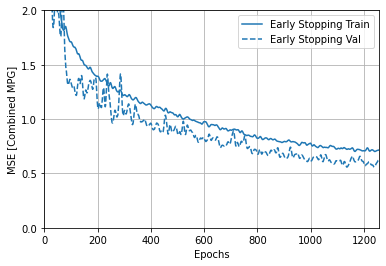

In [21]:
nn_plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
nn_plotter.plot({'Early Stopping': nn_history}, metric = "mse")
plt.rc("figure", figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.ylim([0, 2])
plt.ylabel('MSE [Combined MPG]')

In [22]:
fitted_nn_model.evaluate(X_test.astype(float),\
                         y_test.astype(float), verbose=0)

[0.8478031754493713, 0.8478031754493713]

In [23]:
y_train_nn_pred = fitted_nn_model.predict(X_train.astype(float))
y_test_nn_pred = fitted_nn_model.predict(X_test.astype(float))
RMSE_nn_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_nn_pred))
RMSE_nn_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_nn_pred))
R2_nn_test = metrics.r2_score(y_test, y_test_nn_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_nn_train, RMSE_nn_test, R2_nn_test))

RMSE_train: 0.8255	RMSE_test: 0.9208	r2: 0.9862


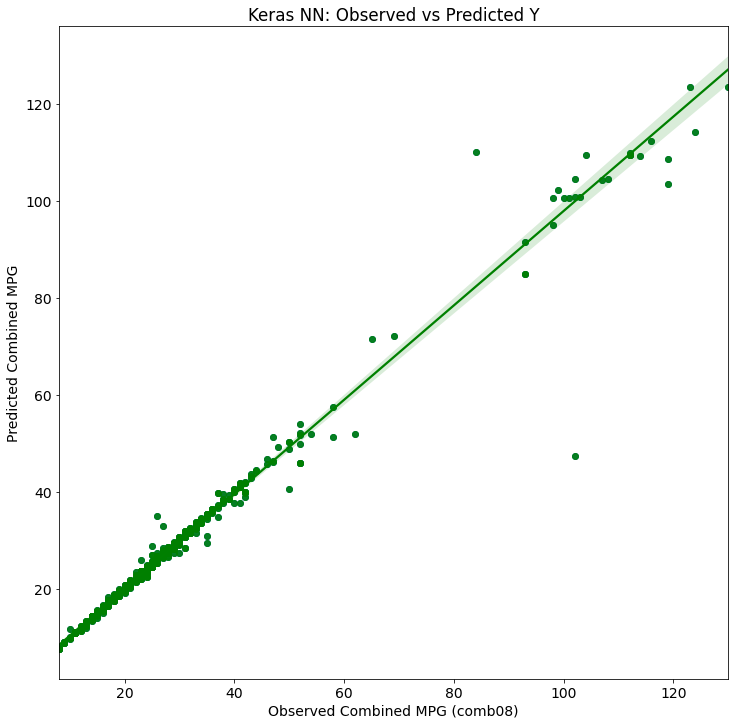

In [24]:
plt.figure(figsize = (12,12))
plt.title('Keras NN: Observed vs Predicted Y')
plt.ylabel('Predicted Combined MPG')
plt.scatter(y_test, y_test_nn_pred)
sns.regplot(x=y_test, y=y_test_nn_pred, color="g")
plt.xlabel('Observed Combined MPG (comb08)')
plt.show() 

In [25]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [26]:
fitted_xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate=0.5,\
                    n_jobs= 4, objective='reg:squarederror',\
                    random_state=rand, verbosity=0).fit(X_train, y_train,\
                    eval_set=[(X_train, y_train),(X_val, y_val)],\
                    eval_metric='rmse')

[0]	validation_0-rmse:11.07063	validation_1-rmse:10.82106
[1]	validation_0-rmse:5.61925	validation_1-rmse:5.47074
[2]	validation_0-rmse:2.90768	validation_1-rmse:2.82786
[3]	validation_0-rmse:1.57359	validation_1-rmse:1.55898
[4]	validation_0-rmse:0.93275	validation_1-rmse:0.98511
[5]	validation_0-rmse:0.66187	validation_1-rmse:0.75239
[6]	validation_0-rmse:0.54061	validation_1-rmse:0.66849
[7]	validation_0-rmse:0.47753	validation_1-rmse:0.64978
[8]	validation_0-rmse:0.45349	validation_1-rmse:0.63991
[9]	validation_0-rmse:0.43844	validation_1-rmse:0.62990
[10]	validation_0-rmse:0.42460	validation_1-rmse:0.63982
[11]	validation_0-rmse:0.42070	validation_1-rmse:0.63883
[12]	validation_0-rmse:0.39969	validation_1-rmse:0.64526
[13]	validation_0-rmse:0.39166	validation_1-rmse:0.64841
[14]	validation_0-rmse:0.38932	validation_1-rmse:0.64896
[15]	validation_0-rmse:0.38052	validation_1-rmse:0.65146
[16]	validation_0-rmse:0.37834	validation_1-rmse:0.66059
[17]	validation_0-rmse:0.37666	validati

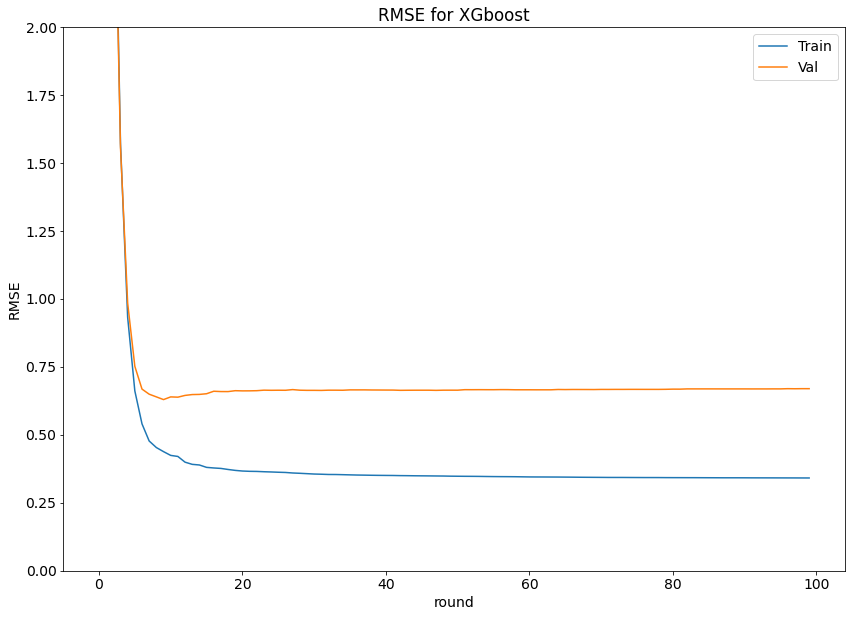

In [27]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.title('RMSE for XGboost')
plt.plot(fitted_xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']['rmse'])
plt.ylabel('RMSE')
plt.ylim([0, 2])
plt.xlabel('round')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [28]:
y_train_xgb_pred = fitted_xgb_model.predict(X_train)
y_test_xgb_pred = fitted_xgb_model.predict(X_test)
RMSE_xgb_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_xgb_pred))
RMSE_xgb_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_xgb_pred))
R2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_xgb_train, RMSE_xgb_test, R2_xgb_test))

RMSE_train: 0.3415	RMSE_test: 0.3876	r2: 0.9976


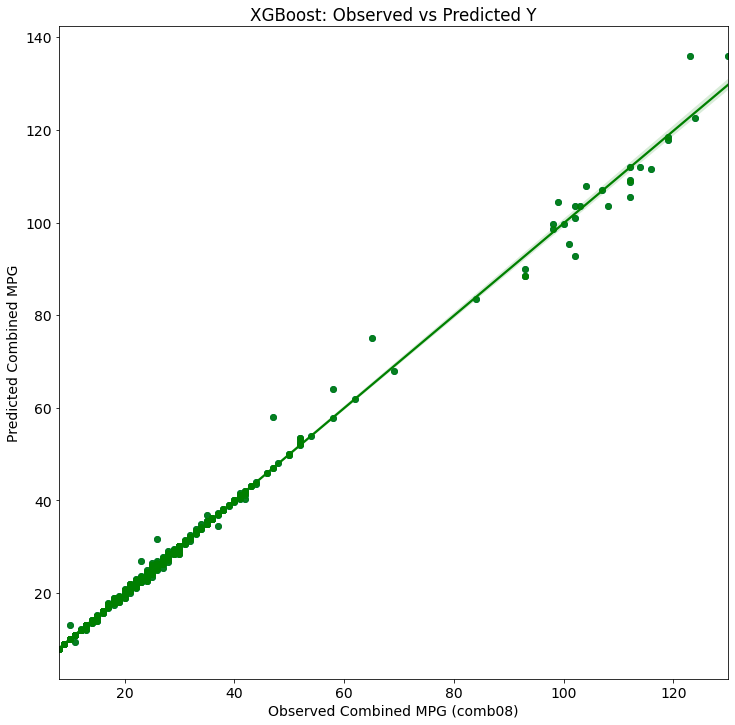

In [29]:
plt.figure(figsize = (12,12))
plt.title('XGBoost: Observed vs Predicted Y')
plt.ylabel('Predicted Combined MPG')
plt.scatter(y_test, y_test_xgb_pred)
sns.regplot(x=y_test, y=y_test_xgb_pred, color="g")
plt.xlabel('Observed Combined MPG (comb08)')
plt.show() 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

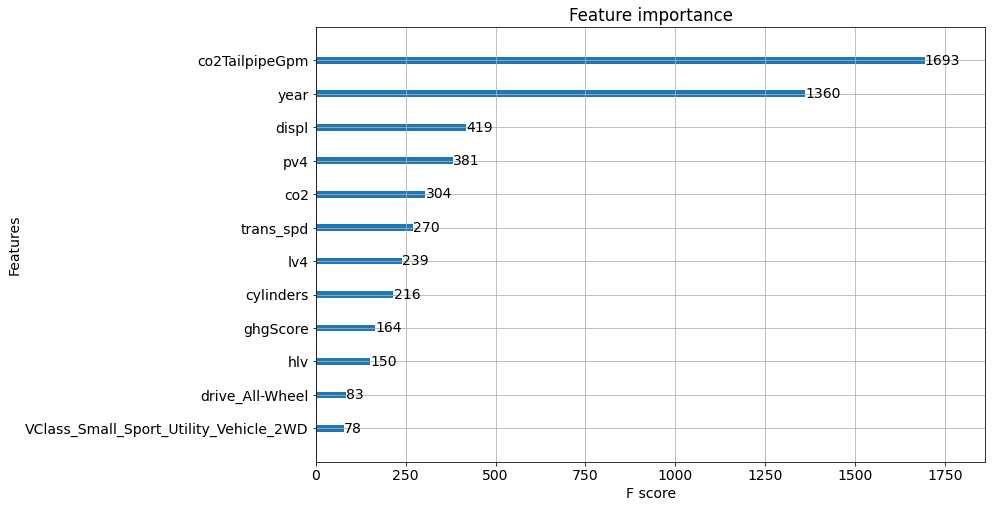

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(fitted_xgb_model, max_num_features=12, ax=ax)

In [31]:
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. Th

In [32]:
shap_xgb_values_train = shap_xgb_explainer.shap_values(X_train)
shap_xgb_values_test = shap_xgb_explainer.shap_values(X_test)

In [33]:
shap_xgb_values_test

array([[-1.11900926e-01,  1.76362682e-03,  4.03838698e-03, ...,
         4.51610613e-05,  7.03286030e-04, -1.31886845e-04],
       [-1.03325397e-01,  4.89023253e-02, -2.44989675e-02, ...,
         2.73336336e-05,  8.63326306e-04, -9.15343771e-05],
       [-2.02256814e-02, -1.37882633e-02,  4.75725567e-04, ...,
         1.00554491e-04,  4.61049203e-04, -1.76106754e-04],
       ...,
       [-6.21439936e-03, -2.25481596e-02, -5.58186846e-04, ...,
        -3.10360520e-05,  9.99440788e-04, -9.42506813e-05],
       [-9.61635262e-02,  1.87829416e-03,  2.50930875e-03, ...,
         4.82059477e-05,  6.81695703e-04, -8.54037717e-05],
       [-8.81952816e-04, -3.32170755e-01, -4.57313564e-03, ...,
         2.10283266e-04,  1.62121258e-03, -7.07093044e-04]], dtype=float32)

In [34]:
shap_xgb_values_test.shape

(6367, 81)

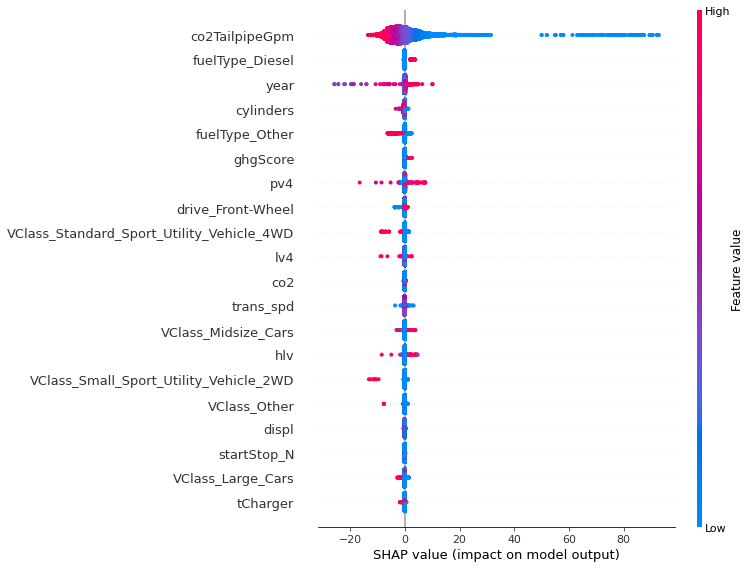

In [35]:
shap.summary_plot(shap_xgb_values_train, X_train, plot_type="dot")

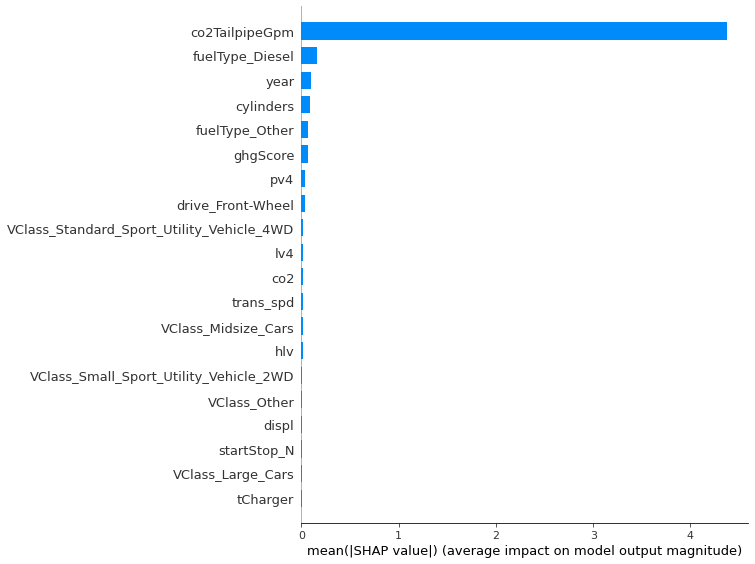

In [36]:
shap.summary_plot(shap_xgb_values_train, X_train, plot_type="bar")

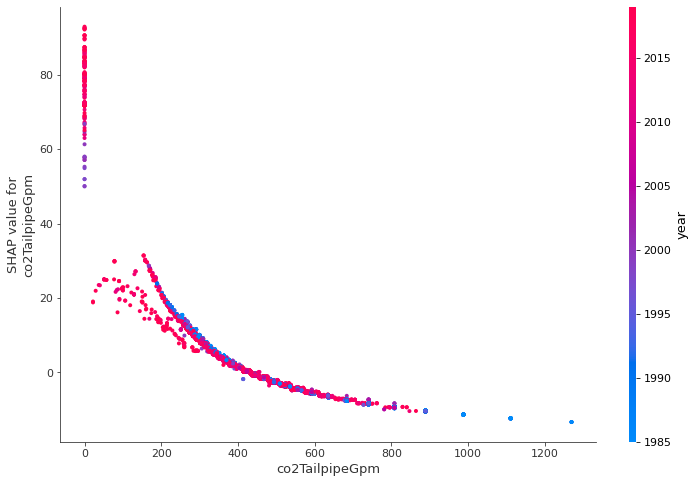

In [37]:
shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_train, X_train,\
                     interaction_index="year", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

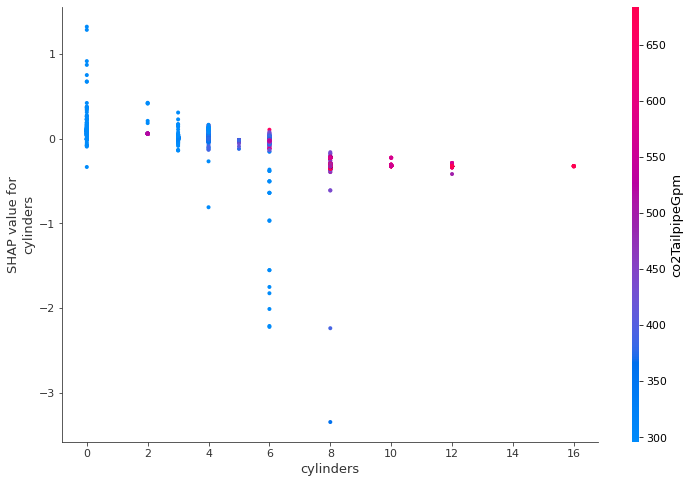

In [38]:
shap.dependence_plot("cylinders", shap_xgb_values_train, X_train,\
                     interaction_index="co2TailpipeGpm", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

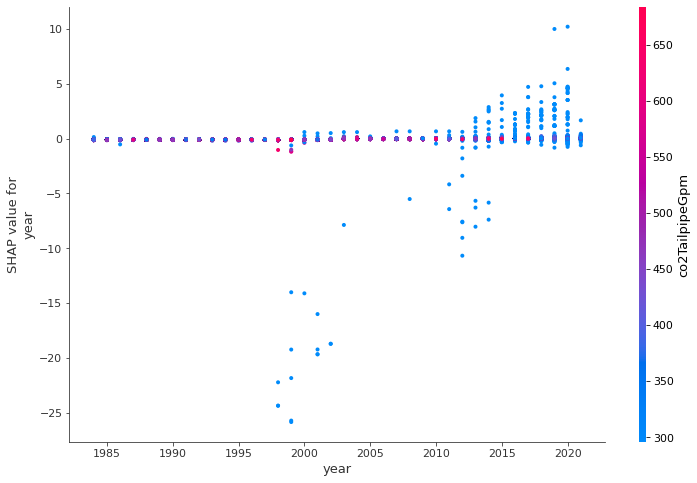

In [39]:
shap.dependence_plot("year", shap_xgb_values_train, X_train,\
                     interaction_index="co2TailpipeGpm", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [40]:
sample_train_size = 0.001
sample_test_size = 0.05
sample_train_idx = np.random.choice(X_train.shape[0],
                                    math.ceil(X_train.shape[0]*sample_train_size),
                                    replace=False)
sample_test_idx = np.random.choice(X_test.shape[0],
                                   math.ceil(X_test.shape[0]*sample_test_size),\
                                   replace=False)

In [41]:
shap.initjs()
shap.force_plot(shap_xgb_explainer.expected_value,\
                shap_xgb_values_test[sample_test_idx],\
                X_test.iloc[sample_test_idx])

In [42]:
shap_nn_explainer = shap.KernelExplainer(fitted_nn_model.predict,\
                                         X_train.iloc[sample_train_idx].astype(float),\
                                         link="identity")

In [43]:
shap_nn_values_test = shap_nn_explainer.shap_values(X_test.iloc[sample_test_idx].astype(float),\
                                                    nsamples=100, l1_reg="num_features(12)")

In [44]:
sample_test_idx.shape

(319,)

In [45]:
shap_nn_values_test

[array([[ 0.16185115,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03689116,  0.        , -0.05030228, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.38369447,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.29443095,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.11556204, ...,  0.        ,
          0.        ,  0.        ]])]

In [46]:
shap_nn_values_test[0].shape

(319, 81)

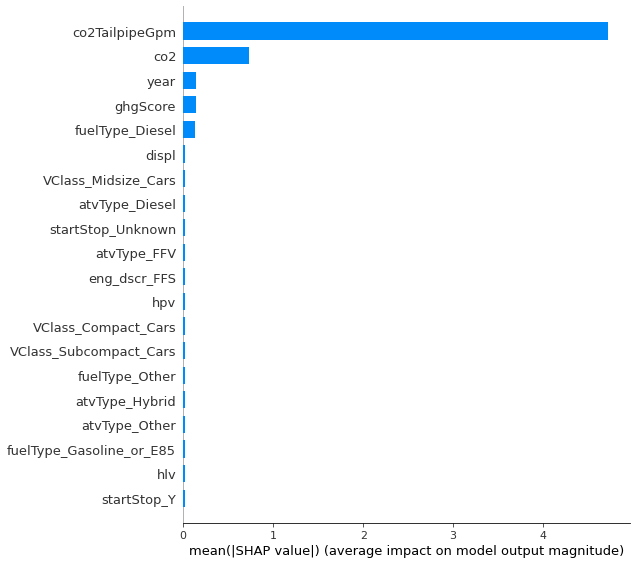

In [47]:
shap.summary_plot(shap_nn_values_test[0], X_test.astype(float), plot_type="bar")

In [48]:
shap_nn_values_test[0].shape

(319, 81)

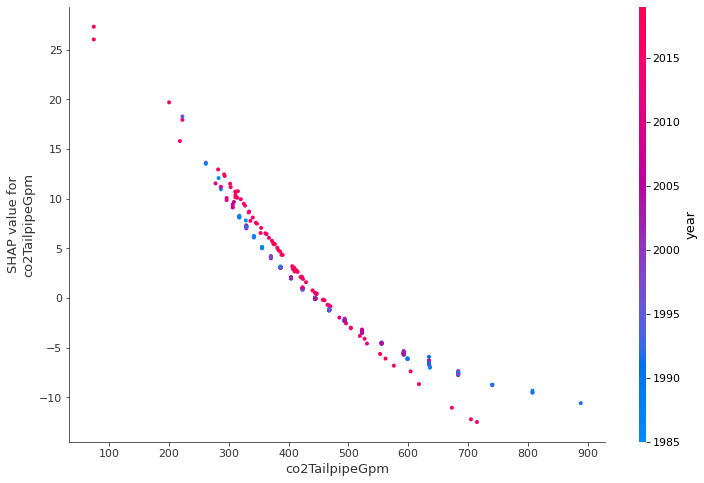

In [49]:
shap.dependence_plot("co2TailpipeGpm", shap_nn_values_test[0],\
                     X_test.iloc[sample_test_idx].astype(float),\
                     interaction_index="year", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

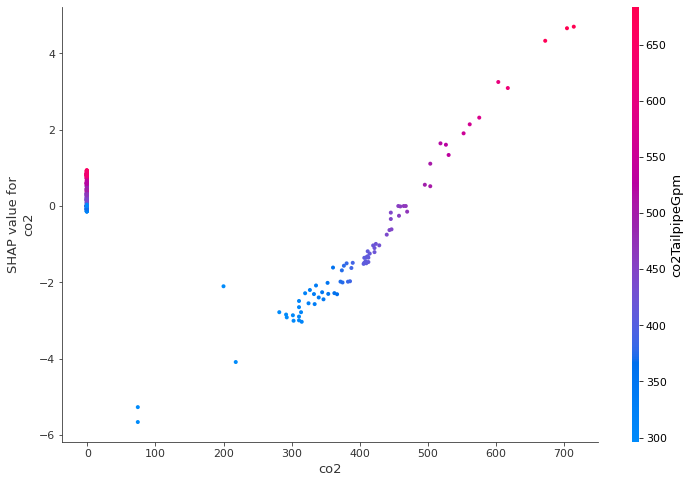

In [50]:
shap.dependence_plot("co2", shap_nn_values_test[0],\
                     X_test.iloc[sample_test_idx].astype(float),\
                     interaction_index="co2TailpipeGpm", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

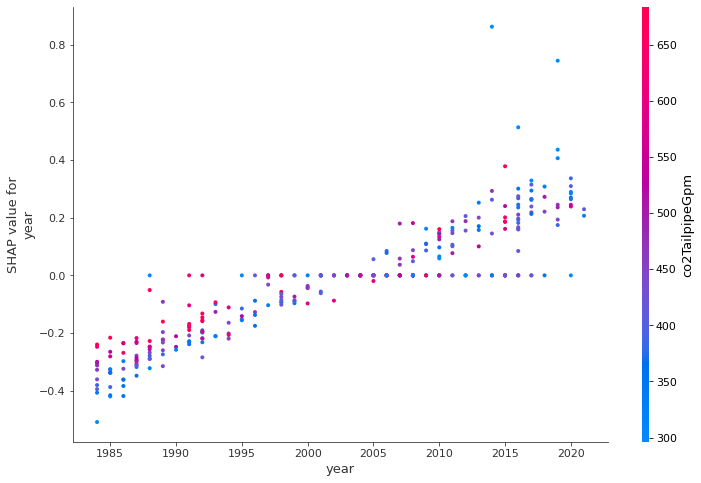

In [51]:
shap.dependence_plot("year", shap_nn_values_test[0],\
                     X_test.iloc[sample_test_idx].astype(float),\
                     interaction_index="co2TailpipeGpm", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [52]:
shap.force_plot(shap_nn_explainer.expected_value, shap_nn_values_test[0], X_test)

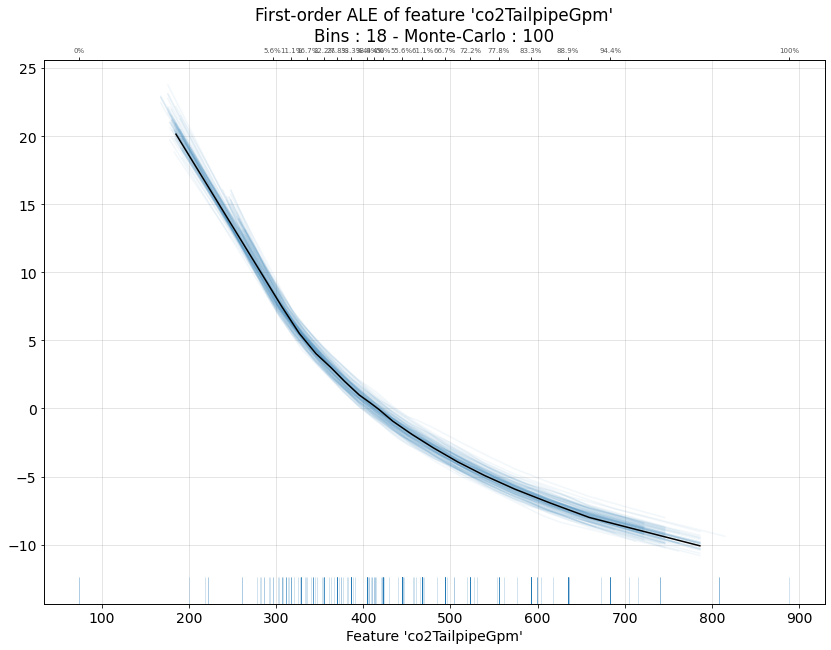

<AxesSubplot:title={'center':"First-order ALE of feature 'co2TailpipeGpm'\nBins : 18 - Monte-Carlo : 100"}, xlabel="Feature 'co2TailpipeGpm'">

In [53]:
plt.rc("figure", figsize=(14, 10))
ale_plot(
    fitted_xgb_model,
    X_test.iloc[sample_test_idx],
    ['co2TailpipeGpm'],
    bins=20,
    monte_carlo=True,
    monte_carlo_rep=100,
    monte_carlo_ratio=0.6
)

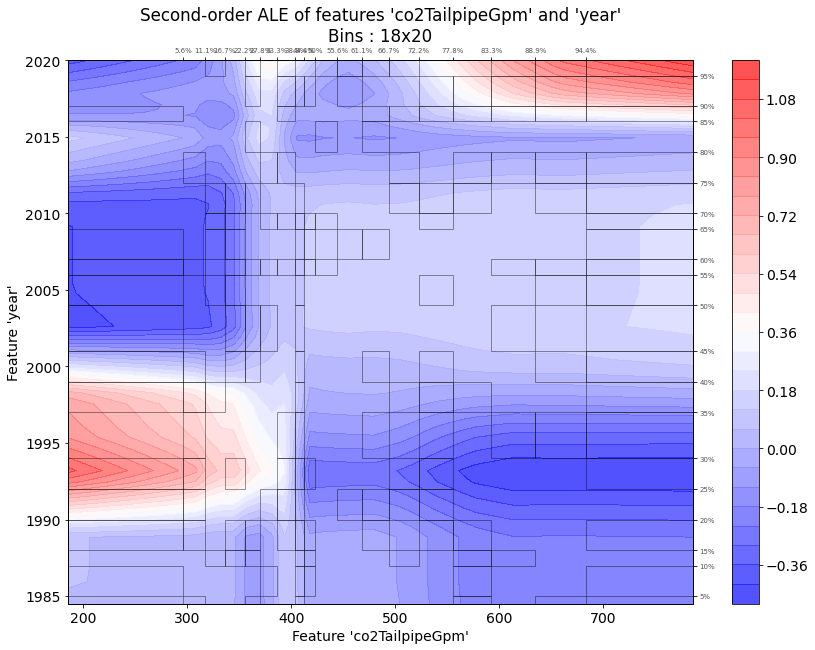

<AxesSubplot:title={'center':"Second-order ALE of features 'co2TailpipeGpm' and 'year'\nBins : 18x20"}, xlabel="Feature 'co2TailpipeGpm'", ylabel="Feature 'year'">

In [54]:
plt.rc("figure", figsize=(14, 10))
ale_plot(
    fitted_xgb_model,
    X_test.iloc[sample_test_idx],
    ['co2TailpipeGpm', 'year'],
    bins=20
)

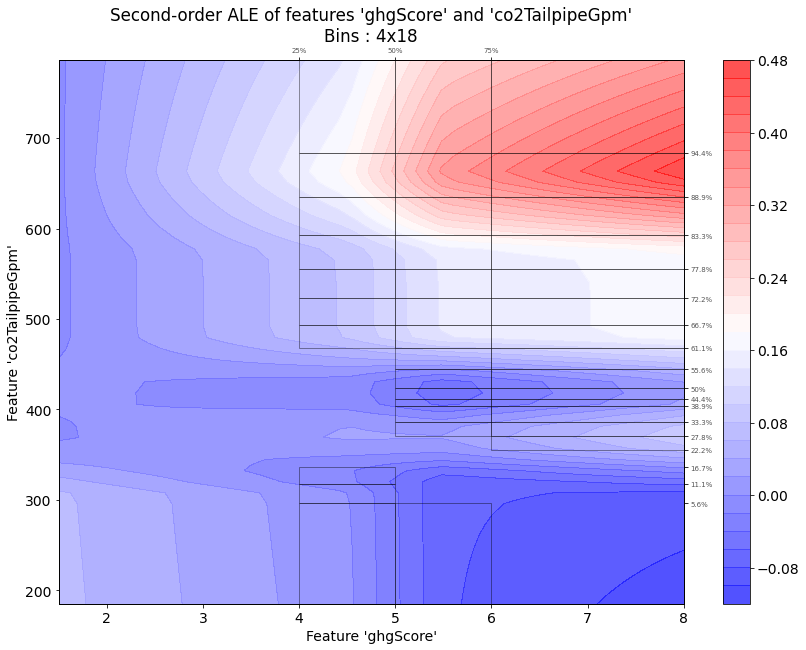

<AxesSubplot:title={'center':"Second-order ALE of features 'ghgScore' and 'co2TailpipeGpm'\nBins : 4x18"}, xlabel="Feature 'ghgScore'", ylabel="Feature 'co2TailpipeGpm'">

In [55]:
plt.rc("figure", figsize=(14, 10))
ale_plot(
    fitted_xgb_model,
    X_test.iloc[sample_test_idx],
    ['ghgScore', 'co2TailpipeGpm'],
    bins=20
)

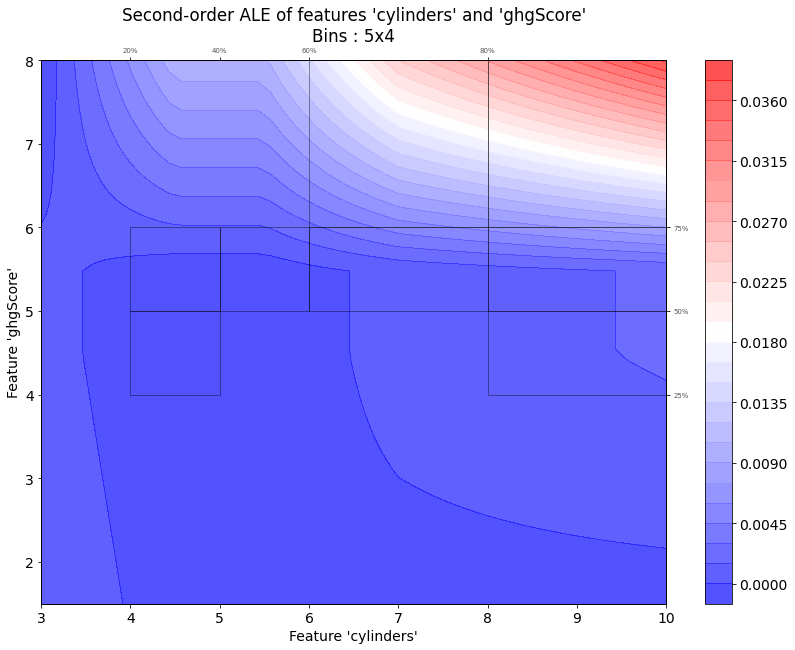

<AxesSubplot:title={'center':"Second-order ALE of features 'cylinders' and 'ghgScore'\nBins : 5x4"}, xlabel="Feature 'cylinders'", ylabel="Feature 'ghgScore'">

In [56]:
plt.rc("figure", figsize=(14, 10))
ale_plot(
    fitted_xgb_model,
    X_test.iloc[sample_test_idx],
    ['cylinders', 'ghgScore'],
    bins=20
)

In [57]:
fitted_dt_surrogate = tree.DecisionTreeRegressor(max_depth=7,\
                                                 random_state=rand).\
                                        fit(X_train, y_train_nn_pred)
y_train_dt_pred = fitted_dt_surrogate.predict(X_train)
y_test_dt_pred = fitted_dt_surrogate.predict(X_test)

In [58]:
fitted_rf_surrogate = RuleFit(max_rules=150, rfmode='regress',\
                              random_state=rand, tree_size=8).\
                        fit(X_train.astype(float).values, y_train_nn_pred.squeeze(),\
                            X_train.columns)
y_train_rf_pred = fitted_rf_surrogate.predict(X_train.astype(float).values)
y_test_rf_pred = fitted_rf_surrogate.predict(X_test.astype(float).values)

In [59]:
#Measure how well Decision Tree replicates Neural Network's predictions
RMSE_dt_nn_train = math.sqrt(\
                    metrics.mean_squared_error(y_train_nn_pred,\
                                               y_train_dt_pred))
RMSE_dt_nn_test = math.sqrt(\
                    metrics.mean_squared_error(y_test_nn_pred,
                                               y_test_dt_pred))
R2_dt_nn_test = metrics.r2_score(y_test_nn_pred, y_test_dt_pred)
#Measure how well Decision Tree predicts against original datasets
RMSE_dt_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_dt_pred))
RMSE_dt_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_dt_pred))
R2_dt_test = metrics.r2_score(y_test, y_test_dt_pred)
#Print all metrics
print('RMSE_nn_train: %.4f\tRMSE_nn_test: %.4f\tr2_nn: %.4f' %\
                (RMSE_dt_nn_train, RMSE_dt_nn_test, R2_dt_nn_test))
print('RMSE_train:    %.4f\tRMSE_test:    %.4f\tr2:    %.4f' %\
                (RMSE_dt_train, RMSE_dt_test, R2_dt_test))

RMSE_nn_train: 0.5516	RMSE_nn_test: 0.7293	r2_nn: 0.9910
RMSE_train:    0.9797	RMSE_test:    0.8073	r2:    0.9894


In [60]:
#Measure how well Rule Fit replicates Neural Network's predictions
RMSE_rf_nn_train = math.sqrt(\
                    metrics.mean_squared_error(y_train_nn_pred,\
                                               y_train_rf_pred))
RMSE_rf_nn_test = math.sqrt(\
                    metrics.mean_squared_error(y_test_nn_pred,
                                               y_test_rf_pred))
R2_rf_nn_test = metrics.r2_score(y_test_nn_pred, y_test_rf_pred)
#Measure how well Rule Fit predicts against original datasets
RMSE_rf_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_rf_pred))
RMSE_rf_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_rf_pred))
R2_rf_test = metrics.r2_score(y_test, y_test_rf_pred)
#Print all metrics
print('RMSE_nn_train: %.4f\tRMSE_nn_test: %.4f\tr2_nn: %.4f' %\
                (RMSE_rf_nn_train, RMSE_rf_nn_test, R2_rf_nn_test))
print('RMSE_train:    %.4f\tRMSE_test:    %.4f\tr2:    %.4f' %\
                (RMSE_rf_train, RMSE_rf_test, R2_rf_test))

RMSE_nn_train: 0.8857	RMSE_nn_test: 1.0359	r2_nn: 0.9819
RMSE_train:    1.2305	RMSE_test:    1.1664	r2:    0.9779


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


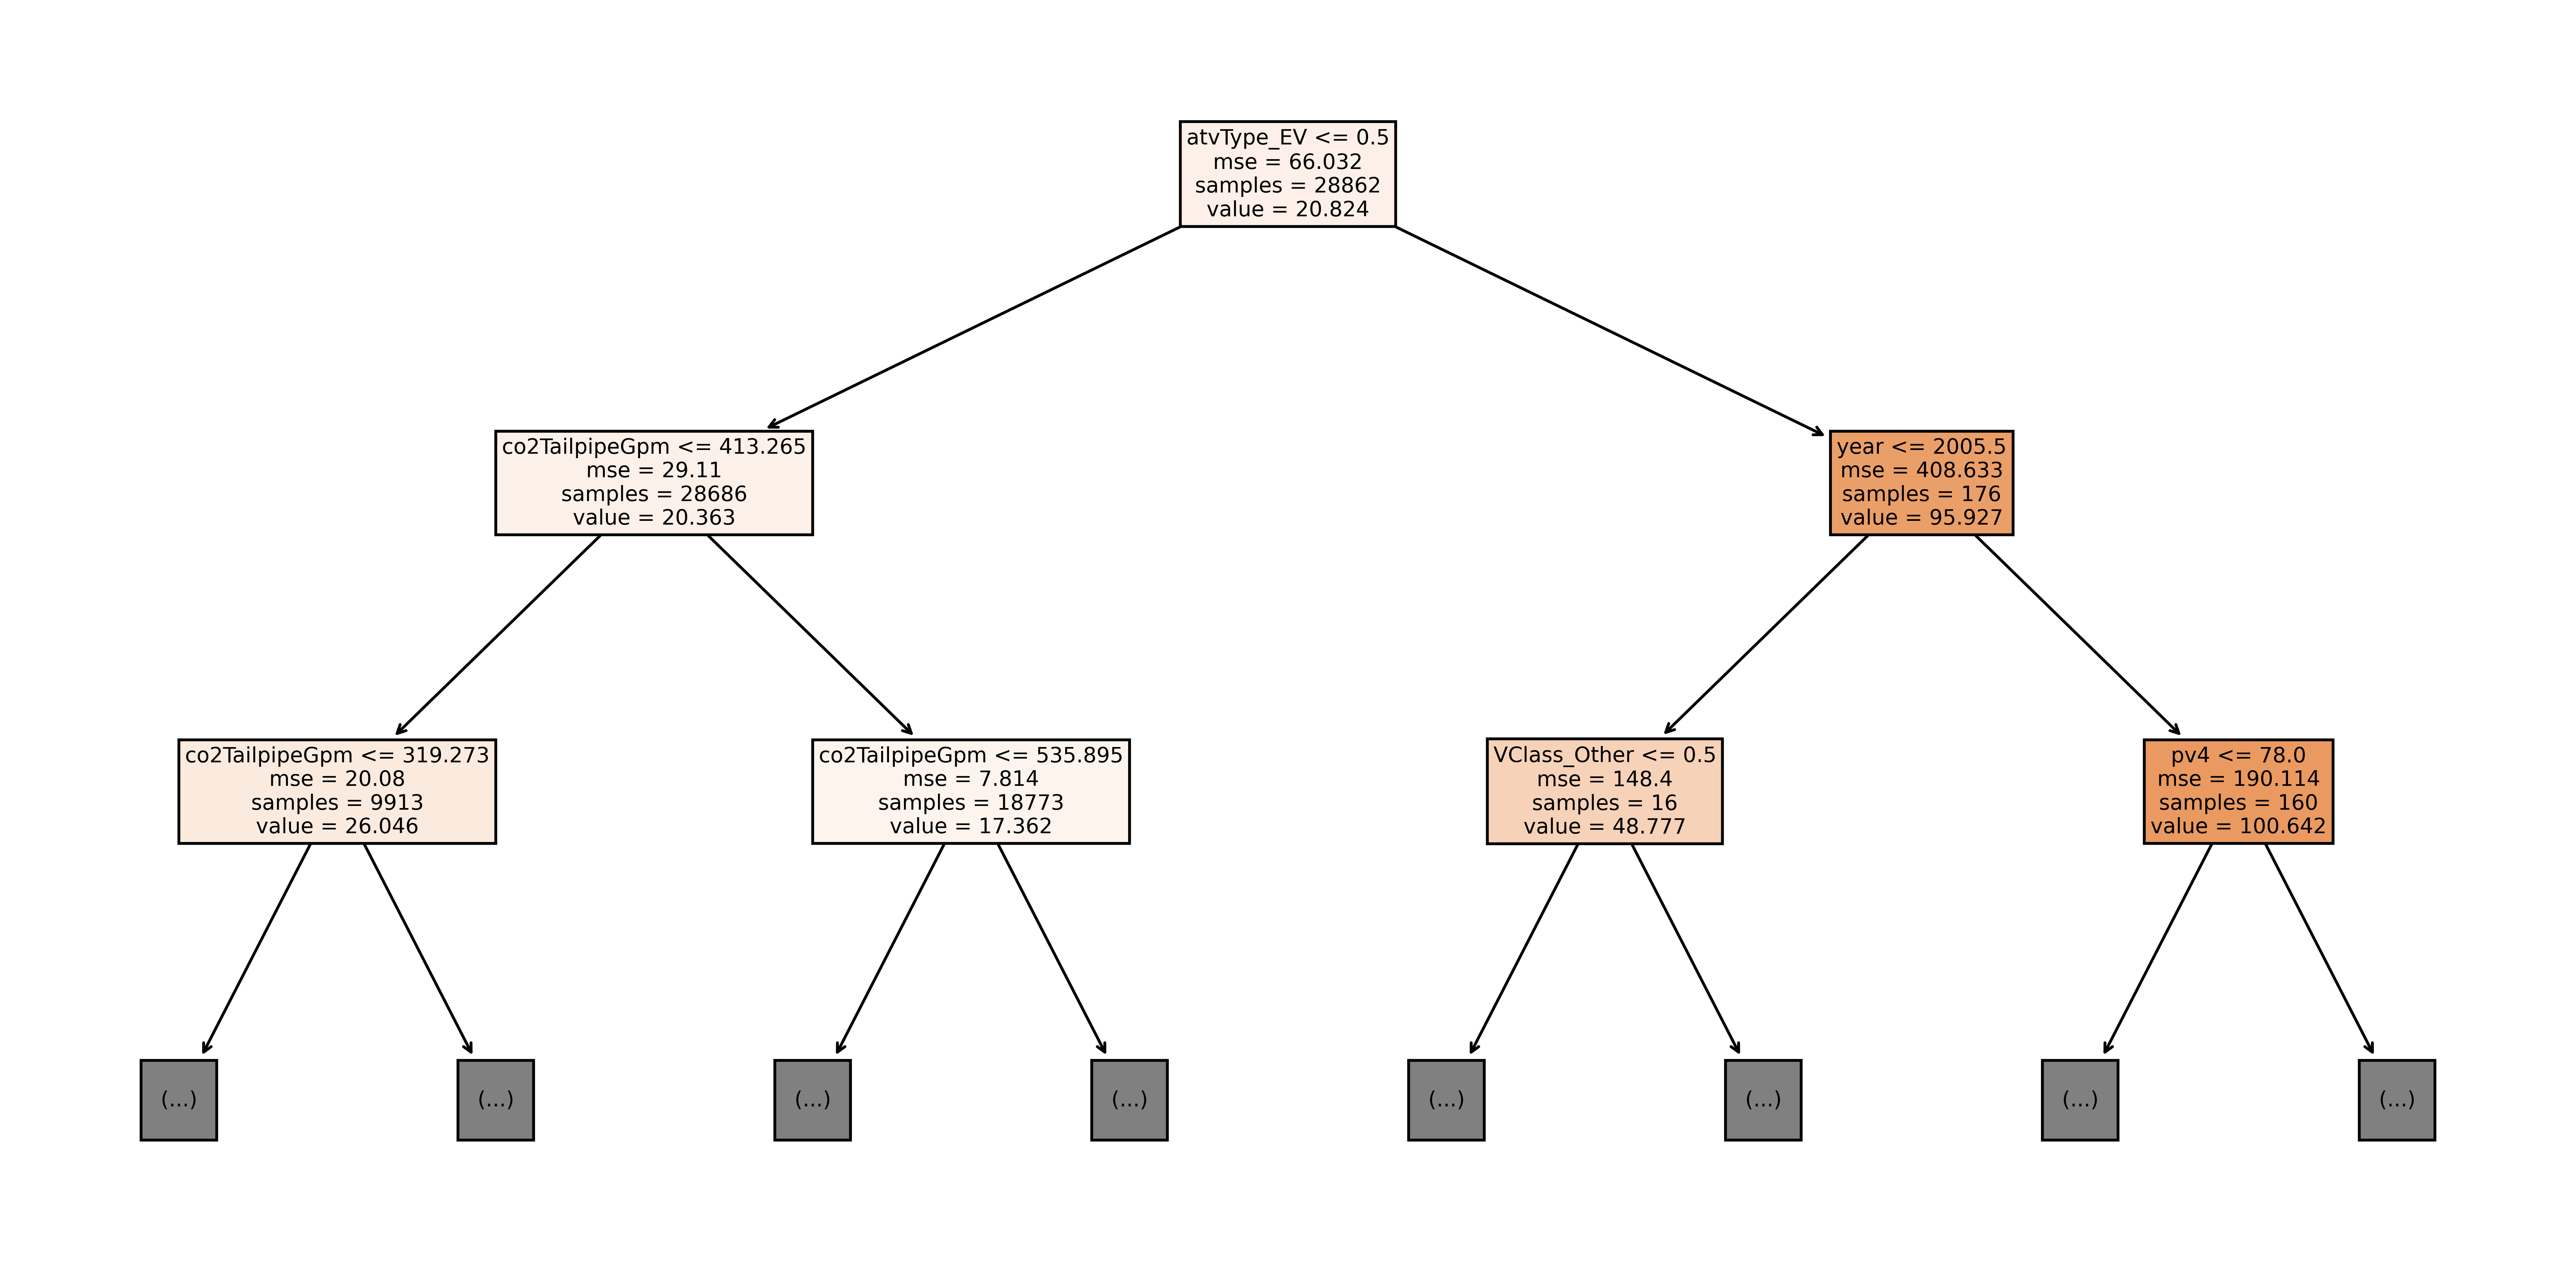

In [61]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [62]:
text_tree = tree.export_text(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- atvType_EV <= 0.50
|   |--- co2TailpipeGpm <= 413.26
|   |   |--- co2TailpipeGpm <= 319.27
|   |   |   |--- co2TailpipeGpm <= 246.93
|   |   |   |   |--- drive_Front-Wheel <= 0.50
|   |   |   |   |   |--- atvType_Other <= 0.50
|   |   |   |   |   |   |--- drive_Part-time_4-Wheel <= 0.50
|   |   |   |   |   |   |   |--- value: [36.53]
|   |   |   |   |   |   |--- drive_Part-time_4-Wheel >  0.50
|   |   |   |   |   |   |   |--- value: [49.84]
|   |   |   |   |   |--- atvType_Other >  0.50
|   |   |   |   |   |   |--- ghgScore <= 9.50
|   |   |   |   |   |   |   |--- value: [24.79]
|   |   |   |   |   |   |--- ghgScore >  9.50
|   |   |   |   |   |   |   |--- value: [28.39]
|   |   |   |   |--- drive_Front-Wheel >  0.50
|   |   |   |   |   |--- hlv <= 19.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 217.50
|   |   |   |   |   |   |   |--- value: [43.05]
|   |   |   |   |   |   |--- co2TailpipeGpm >  217.50
|   |   |   |   |   |   |   |--- value: [38.34]
|   |   |   |   |   |--- h

In [63]:
rulefit_df = fitted_rf_surrogate.get_rules()

In [64]:
rulefit_df = rulefit_df[rulefit_df.coef != 0]
rulefit_df.shape

(85, 5)

In [65]:
rulefit_df.sort_values(by="importance", ascending=False)

rule    type          coef  \
4                                       co2TailpipeGpm  linear -3.066502e-02   
197       displ <= 0.30000001192092896 & year > 2007.5    rule  2.763035e+01   
128  cylinders <= 1.5 & ghgScore > 4.5 & co2Tailpip...    rule  1.917248e+01   
116  year > 2008.0 & lv4 > 14.5 & co2TailpipeGpm <=...    rule  1.462525e+01   
97   atvType_EV <= 0.5 & co2TailpipeGpm > 393.26922...    rule -1.335176e+00   
..                                                 ...     ...           ...   
10                                                 pv2  linear  5.516042e-05   
69                              VClass_Subcompact_Cars  linear  3.284009e-03   
139  fuelType_Electricity > 0.5 & VClass_Standard_S...    rule -5.412146e-03   
89   cylinders > 1.0 & co2TailpipeGpm > 511.5 & co2...    rule -2.656494e-05   
201                         fuelType_Electricity > 0.5    rule  1.624778e-16   

      support    importance  
4    1.000000  3.458363e+00  
197  0.008937  2.600292e+00  
128  0.001787  8.098224e-01  
116  0.001787  6.177527e-01  
97   0.709562  6.061226e-01  
..        ...           ...  
10   1.000000  1.684310e-03  
69   1.000000  1.087405e-03  
139  0.001787  2.286025e-04  
89   0.252011  1.153363e-05  
201  0.007149  1.368882e-17  

[85 rows x 5 columns]